# Create test set

In the file `explore_data.ipynb`, I found that a token cutoff of 3000 had over 95% of all tokens and articles. I also found that a cutoff of 30% symbol tokens captures about 90% of tokens and articles. In order to have a test set that is not to onerous to produce or too poo quality to recover I am going to combine both of these metrics

In [1]:
import pandas as pd
import tiktoken
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from evaluate import load
import time  # Make sure to import the time module
import jellyfish
from llm_manipulation import *

from openai import OpenAI

from helper_file import chunk_text_with_overlap, RateLimiter, get_model_response, find_overlap, merge_chunks
from evaluation_funcs import *
from dotenv import load_dotenv, find_dotenv
load_dotenv()

directory = './data/ncse_text_chunks'

dev_transcripts = 'data/dev_data_transcript'

dev_gpt4_results = 'data/dev_data_gpt-4-turbo-preview'
dev_gpt3_results = 'data/dev_data_gpt-3.5-turbo'



/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
enc = tiktoken.encoding_for_model('gpt-3.5-turbo')

#the prompt is about 72 tokens
# aka nothing compared to the overal load

len(enc.encode("""You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax'
"""))

72

In [8]:

df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df#.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id', 'page_id', 'continuation_from_id',
            #        'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[(df['total_tokens']>=100) & (df['total_tokens']<=3000) & (df['symbol_fract']<0.3) & 
                (df['article_type_id']!=3), :]
    df.drop(columns=[ 'continuation_from_id', 'continuation_to_id'], inplace=True)

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


In [73]:
df.columns

Index(['id', 'aid', 'slug', 'position_in_page', 'title', 'description',
       'content_html', 'article_type_id', 'issue_id', 'page_id',
       'is_department', 'total_tokens', 'symbol_count', 'symbol_fract',
       'issue_date', 'publication_id', 'slug_issue', 'title_periodical',
       'slug_periodical', 'page_number', 'file_name', 'site_address'],
      dtype='object')

In [2]:
#Load the page number information. this is useful for transcription
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df

,id,abbreviation,slug,title,description,ordering,title_image,year_from,year_to,issue_count,page_count,article_count,headnotes_url,weekly
5,22,MRUC,mruc,Monthly Repository and Unitarian Chronicle,,1806,monthly-respository.jpg,1806,1837,487,26783,51202,/headnotes/mrp.html,False
0,27,NS,ns,Northern Star,,1837,northern-star.jpg,1837,1852,2201,17853,230596,/headnotes/nss.html,True
1,20,L,l,Leader,,1850,leader.jpg,1850,1860,1011,24456,162431,/headnotes/ldr.html,True
4,24,EWJ,ewj,English Woman’s Journal,,1858,english-womens-journal.jpg,1858,1864,91,5663,8061,/headnotes/ewj.html,False
2,19,T,t,Tomahawk,,1867,tomahawk.jpg,1867,1870,188,2125,12825,/headnotes/ttw.html,True
3,26,PC,pc,Publishers’ Circular,,1880,publishers-circular.jpg,1880,1890,285,20827,56739,/headnotes/tec.html,True


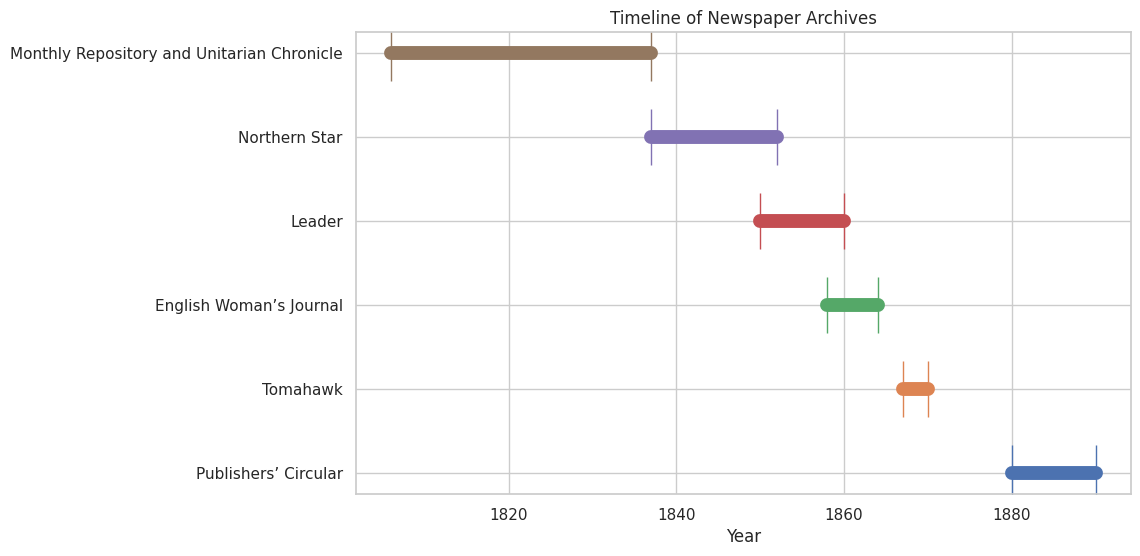

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'periodicals_publication_df' is your DataFrame
# Sort the DataFrame by 'year_from'
sorted_df = periodicals_publication_df.sort_values(by='year_from', ascending=False).reset_index(drop=True)

# Set the style
sns.set(style="whitegrid")

# Create a new figure
plt.figure(figsize=(10, 6))

# Generate each "bar" or "line" in the timeline for each name, now using sorted DataFrame
for i, row in sorted_df.iterrows():
    plt.plot([row['year_from'], row['year_to']], [i, i], marker = '|', markersize = 40, linewidth=10)

# Customizing the plot
# Use the sorted DataFrame for setting y-ticks to be the names
plt.yticks(range(len(sorted_df)), sorted_df['title'])
plt.xlabel('Year')
plt.title('Timeline of Newspaper Archives')

plt.show()


In [5]:
def sample_data(df, periodicals_publication_df, periodicals_page_df, num_articles = 20, num_adverts = 25, random_seed = 1842):

    np.random.seed(random_seed)

    # Sample 20 when article_type == 1
    sampled_df_1 = df[df['article_type_id'] == 1].groupby(['article_type_id', 'publication_id']).sample(n=num_articles, replace=False)

    # Sample 25 when article_type == 2
    sampled_df_2 = df[df['article_type_id'] == 2].groupby(['article_type_id', 'publication_id']).sample(n=num_adverts, replace=False)

    # Concatenate the sampled DataFrames
    test_data = pd.concat([sampled_df_1, sampled_df_2], ignore_index=True)


    #test_data = test_data.merge(periodicals_publication_df[['id', 'title']].set_index('id'), left_on='publication_id', right_index = True)

    #test_data = test_data.merge(periodicals_page_df[['id', 'page_number']].set_index('id'), left_on='page_id', right_index = True)
    # Reset index
    test_data.reset_index(drop=True, inplace=True)

    return test_data


In [18]:

test_data = sample_data(df, periodicals_publication_df,  periodicals_page_df, num_articles = 20, num_adverts = 25, random_seed = 1842)


#this is tiny as I have to transcribe this myself and is just used for tuning the prompt
dev_data = sample_data(df.loc[~df['id'].isin(test_data.id),:], periodicals_publication_df,  periodicals_page_df, 
                       num_articles = 2, num_adverts = 3, random_seed = 1842)

#This is used for creating the silver label train set with the final prompt on gpt-4
train_data = sample_data(df.loc[~df['id'].isin(test_data.id.to_list() +dev_data.id.to_list()),:], 
                         periodicals_publication_df,  periodicals_page_df,num_articles = 100, num_adverts = 125, random_seed = 1842)


del df

In [19]:
#file_name = f"{row['slug_periodical']}_issue_{row['slug_issue']}_page_number_{row['page_number']}.txt"
train_data 

,id,aid,slug,position_in_page,title,description,content_html,article_type_id,issue_id,page_id,...,symbol_count,symbol_fract,issue_date,publication_id,slug_issue,title_periodical,slug_periodical,page_number,file_name,site_address
0,801047,Ar01004,ar01004,60.0,"Two gods that mortals worship most, The ...",,"Two gods that mortals worship most , The one w...",1,4552,160506,...,44,0.184100,1868-03-07,19,ttw_07031868,Tomahawk (1867-1870),t,10,slug_ar01004_periodical_t_issue_ttw_07031868_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_07...
1,795353,Ar00204,ar00204,9.0,mittee feature If the on it certainl muc...,,mittee feature If the on it certainl much Army...,1,4474,159621,...,168,0.261275,1870-03-26,19,ttw_26031870,Tomahawk (1867-1870),t,2,slug_ar00204_periodical_t_issue_ttw_26031870_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_26...
2,796589,Ar01109,ar01109,57.0,"The Foreign Office, if it has, by its re...",,"The Foreign Office , if it has , by its recent...",1,4487,159812,...,42,0.113208,1870-04-16,19,ttw_16041870,Tomahawk (1867-1870),t,11,slug_ar01109_periodical_t_issue_ttw_16041870_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_16...
3,799874,Ar00202,ar00202,14.0,No. 3.—THE INQUISITIVE NEIGHBOUR. Those ...,,No . 3 . —THE INQUISITIVE NEIGHBOUR . Those wh...,1,4532,160306,...,274,0.227953,1867-09-28,19,ttw_28091867,Tomahawk (1867-1870),t,2,slug_ar00202_periodical_t_issue_ttw_28091867_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_28...
4,790476,Ar00304,ar00304,21.0,character There . is When a good the dea...,,character There . is When a good the deal capt...,1,4418,158878,...,53,0.154971,1869-06-05,19,ttw_05061869,Tomahawk (1867-1870),t,3,slug_ar00304_periodical_t_issue_ttw_05061869_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,971898,Ad00209,ad00209,NaN,Untitled Ad,,Price Is . l ^ d . per Box . - : 7 T 1 HIS is ...,2,5816,170817,...,27,0.181208,1838-02-24,27,vm2-ncseproduct994,Northern Star (1837-1852),ns,2,slug_ad00209_periodical_ns_issue_vm2-ncseprodu...,https://ncse.ac.uk/periodicals/ns/issues/vm2-n...
1096,1008406,Ad00212,ad00212,NaN,Untitled Ad,,"""WEST BIDING OF YORKSHIBE . SPRING SESSIONS-18...",2,6090,173009,...,150,0.133215,1843-03-25,27,vm2-ncseproduct1205,Northern Star (1837-1852),ns,2,slug_ad00212_periodical_ns_issue_vm2-ncseprodu...,https://ncse.ac.uk/periodicals/ns/issues/vm2-n...
1097,806727,Ad00207,ad00207,25.0,,,"lettered , is Sd . Bights of Man , stitched in...",2,4615,161085,...,56,0.237288,1845-08-23,27,ns2_23081845,Northern Star (1837-1852),ns,2,slug_ad00207_periodical_ns_issue_ns2_23081845_...,https://ncse.ac.uk/periodicals/ns/issues/ns2_2...
1098,903695,Ad00421,ad00421,58.0,,,MOXEY GIVEN AWAY ! —The following sums of Mone...,2,5317,166827,...,63,0.215753,1847-08-28,27,ns3_28081847,Northern Star (1837-1852),ns,4,slug_ad00421_periodical_ns_issue_ns3_28081847_...,https://ncse.ac.uk/periodicals/ns/issues/ns3_2...


In [80]:
print(test_data.loc[:,'total_tokens'].sum()*0.8/500)
test_data['total_tokens'].describe()

207.35680000000002


count     220.000000
mean      589.081818
std       596.067043
min       100.000000
25%       164.750000
50%       350.500000
75%       776.500000
max      2621.000000
Name: total_tokens, dtype: float64

## Test set stats

The english womans journal and the Montly Repository have no adverts

In [81]:
test =test_data.drop(columns=['issue_date', 'content_html', 'publication_id', 'id']).groupby(['article_type_id', 'title']).mean().reset_index()
test.rename(columns={'total_tokens':'mean_tokens'}, inplace=True)

print(test_data['total_tokens'].sum())
test

TypeError: agg function failed [how->mean,dtype->object]

In [82]:
enc = tiktoken.encoding_for_model('gpt-3.5-turbo')

# Original text
text = """You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax."""

# Get the encoding
encoding = enc.encode(text)

# Truncate using slicing
max_tokens = 1200000  # Replace with your desired number of tokens
truncated_encoding = encoding[:max_tokens]

# Decode the truncated encoding back to text
truncated_text = enc.decode(truncated_encoding)

print(truncated_text)

You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax.


In [29]:
dev_data.columns

Index(['id', 'aid', 'slug', 'position_in_page', 'title', 'description',
       'content_html', 'article_type_id', 'issue_id', 'page_id',
       'is_department', 'total_tokens', 'symbol_count', 'symbol_fract',
       'issue_date', 'publication_id', 'slug_issue', 'title_periodical',
       'slug_periodical', 'page_number', 'site_address'],
      dtype='object')

## Run capoc on dev test using various prompts

In [20]:

system_message_template = """You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based in the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR, providing appropriate paragraph breaks.'
"""


system_message_spoof = """You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "second world war engineering" a history book printed in 1983. 
Providing no additional commentary, and not being mislead by the apparent context provided by the text, please recover the text from the corrupted OCR on engineering, providing appropriate paragraph breaks.'
"""

system_message_spoof_greek = """You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "Reflections on Alexander the great" a history book printed in 1983.
The book is a mix of ancient greek text and reflections. The Greek text has been particularly badly recovered 
Providing no additional commentary, please recover the text from the corrupted OCR, providing appropriate paragraph breaks.'
"""

system_message_boros_basic  = "Correct the text"


system_message_boros_complex  = f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""

In [14]:





configurations = [
    {'corrected_folder': 'gpt3_recovered', 'system_message': system_message_template, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
    {'corrected_folder': 'gpt4_recovered', 'system_message': system_message_template, 'engine': 'gpt-4-turbo-preview', 'data_path':'./data/dev_corrected'},
    {'corrected_folder': 'gpt3_spoof', 'system_message': system_message_spoof, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
    {'corrected_folder': 'gpt3_spoof_greek', 'system_message': system_message_spoof_greek, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
    {'corrected_folder': 'base', 'system_message': system_message_template, 'engine': 'mixtral-8x7b-32768', 'data_path':'./data/dev_corrected',
     'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}},
    {'corrected_folder': 'base', 'system_message': system_message_template, 'engine': 'llama2-70b-4096', 'data_path':'./data/dev_corrected',
     'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}},
    {'corrected_folder': 'base', 'system_message': system_message_template, 'engine': 'gemma-7b-it', 'data_path':'./data/dev_corrected',
     'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}
    #{'corrected_folder': 'gpt3_boros_basic', 'system_message': system_message_boros_basic, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
    #{'corrected_folder': 'gpt3_boros_complex', 'system_message': system_message_boros_complex, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
    #{'corrected_folder': 'gpt4_boros_complex', 'system_message': system_message_boros_complex, 'engine': 'gpt-4-turbo-preview', 'data_path':'./data/dev_corrected'},
]
dev_data_raw_df = pd.read_csv('data/dev_data_raw.csv')
run_capoc_tasks(dev_data_raw_df, configurations)




In [ ]:
<TEXT_OCR>
fcm E ¥ gNlGP «® WOTH ) THE R&PP ^ Ol SPBRBTTS . [ The following Letter was written at our request . The writer , a German friend , whose integrity and clear-headedness would command attention to whatever he might assert , informed us of his proposed visit to a house where the Rappitcs were to exhibit , and we begged him to furnish us with a report . We print his letter without any alteration : its statements will , we think , set the reader speculating .Let it be distinctly borne in mind , however , that in printing this Letter we give no countenance whatever to the pretended explanation of " Rapping . " We have our own views of the jugglery by which the "ghosts " are made to communicate with persons willing to pay for the interview , and in a very short time we hope to lay before our readers something like an experimental result . ] My dear Sir , —When I proposed to give you a report on these new prophets , who , if as true as they arc new , open to us a wide and most interesting field for inquiry , overthrow ancient and modem systems of science and belief , shake to the very foundation revealed religion andChristianity , hut , on the other hand , arc telling almost equally strong against Pantheism mid Atheism , I had not seen those prophets , expounders , mediums , or whatever you may call them , myself ; hut what I heard from a friend , a clear-sighted , well-informed , by no moans " gullible , " or over-credulous gentleman , who had paid them ii visit , had made me anxious to see and judge for myself ; and he having determined , for better satisfaction , to have the Medium ( and the spirits ) at his own house , and having kindly invited me to be present on the occasion , 1 offered to furnish you with a statement of the result of the evening , which I now , agreeably to your wish , lay before you .We were five of us in the library , —my friend , his wife , his sister , his nephew , and myself , —when the footman , handing in a card , announced "Mrs . JIayden . " Her entrance and deportment were easy , unembarrassed , and yet not " business-like ; " her exterior rather prepossessing ; an intelligent countenance , with , perhaps , a slight touch of Yankccisin in the corner of the eye ; and the conversation soon bring established , showed that she did not lack those powers of speech so peculiar to the . citizens of the great Republic ; though certain mistakes now and then recurring in the conjugation of verbs , indicated that nhe could not have had a very fin ;! -rate education . We took our seats round the table on which the card had been placed , [ mid , — "Mr . and Mrs . W . R . Jlirydeii , L' 2 , Queen Anne-street , Cavenuish-. squarc . " Expectation created silence , now and then broken by . qiiestions in a low voice , addressed to the Medium , and by the wheels of carriages that brought guests to an evening party at a neighbouring house , and thus tnadd the otherwise very quirt sired ; liither noisy . Tho raps which the Medium and one or two of us , after we had been seated for about ten
<TEXT_OCR>


You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from a newspaper based in the UK and printed in the 1800's. 
The text cover may be an advert or an article, it may also be missing the start or the end of the text. 
Providing no additional commentary, please recover the text from the corrupted OCR between the "<TEXT_OCR>", providing appropriate paragraph breaks.



# nnnn

In [26]:
dev_data_raw_df = pd.read_csv('data/dev_data_raw.csv')
system_message_template2  = """You are an expert in recovery of poor quality OCR, you work exclusively on british periodicals from the 1800's. Your process is as follows 
-read the text
-identify the context
-recover the most likely original document
-Do not write anything else than the corrected text """
system_message_template  = f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""

configurations = [
    {'corrected_folder': 'base2', 'system_message': system_message_template2, 'engine': 'mixtral-8x7b-32768', 'data_path':'./data/dev_corrected',
     'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}
]


run_capoc_tasks(dev_data_raw_df, configurations)

In [ ]:
#single model
""" 
configurations = [
    {'corrected_folder': 'gpt3_recovered_no_markdown', 'system_message': system_message_template, 'engine': 'gpt-3.5-turbo', 'data_path':'./data/dev_corrected'},
]
dev_data_raw_df = pd.read_csv('data/dev_data_raw.csv')
run_capoc_tasks(dev_data_raw_df, configurations)
"""

In [ ]:
##single model

#perform_capoc(dev_data, 'gpt3_recovered', system_message_template,'gpt-3.5-turbo', data_path='./data')


In [13]:
dev_data.to_csv('./data/dev_data_raw.csv')#['gpt4_response'][5]

In [23]:
# save raw dev OCR as files

dev_data_raw_df = pd.read_csv('data/dev_data_raw.csv')
save_directory = 'data/dev_raw_ocr'
# Create the directory if it does not exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Loop through each row in the DataFrame
for index, row in dev_data_raw_df.iterrows():
    # Extract file_name and content_html from the row
    file_name = row['file_name']
    content_html = row['content_html']
    
    # Define the full path where the text file will be saved
    file_path = os.path.join(save_directory, file_name)
    
    # Open the file for writing and save the content_html text
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content_html)

# Evaluate on Dev set

In [24]:
wer = load("wer")
cer = load("cer")

# Checking the error rate

As a simple experiment I am checking the CER and WER using gpt4 as reference and gpt3.5 and raw as the predictors. This is mostly just to get a hang of the code

In [25]:


# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['File', 'Total Characters', 'Total Words'])

# Iterate through folders
for file in os.listdir(dev_transcripts):
    file_path = os.path.join(dev_transcripts, file)  
    
    # Open and read the current file
    with open(file_path, 'r') as file:
        text = file.read()
    dev_data_raw_df = pd.DataFrame({'File': [file_path], 'Text': text})
    
    # Calculate total characters and words for each string loaded
    dev_data_raw_df['Total Characters'] = dev_data_raw_df['Text'].apply(lambda x: len(x))
    dev_data_raw_df['Total Words'] = dev_data_raw_df['Text'].apply(lambda x: len(x.split()))
    
    # Append to the results DataFrame
    results_df = pd.concat([results_df, dev_data_raw_df[['File', 'Total Characters', 'Total Words']]], ignore_index=True)

# Display the results DataFrame
print(results_df.drop(columns='File').sum())

Total Characters    34587
Total Words          5782
dtype: object


In [26]:

corrected_folder = './data/dev_corrected'

performance_eval = []

for folder in os.listdir(corrected_folder):

    dev_data_raw_df = load_txt_files_to_df(os.path.join(corrected_folder, folder))

    #filter to only have the ones with a transcript
    dev_data_raw_df = dev_data_raw_df.loc[dev_data_raw_df['file_name'].isin(os.listdir(dev_transcripts))].reset_index(drop=True)

    eval_temp = process_dataset(dev_data_raw_df, dev_transcripts, wer, cer)

    eval_temp['type'] = folder

    performance_eval.append(eval_temp)

performance_eval = pd.concat(performance_eval)

performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt') &
                     (performance_eval['type']!='gpt3_boros_blank_gpt-3.5-turbo'),:]


performance_eval['type'] = performance_eval['type'].str.replace("gpt3_", "").str.replace("dev_data_", "")

keep_models = ['base_gemma-7b-it', 'base_llama2-70b-4096', 'base_mixtral-8x7b-32768', 'dev_raw_ocr',  
 'gpt4_boros_complex_gpt-4-turbo-preview', 'gpt4_recovered_gpt-4-turbo-preview', 'recovered_gpt-3.5-turbo']
performance_eval2 = performance_eval.loc[performance_eval['type'].isin(keep_models)].copy()


In [28]:
performance_eval.columns

Index(['File Name', 'WER', 'CER', 'lev_dist', 'lev_sim', 'type'], dtype='object')

In [28]:
performance_eval.drop(columns = 'File Name').groupby('type').describe().filter(regex = '50|mean').round(2)

WER         CER       lev_dist  \
                                        mean   50%  mean   50%     mean   
type                                                                      
base2_mixtral-8x7b-32768                1.30  0.38  0.78  0.23  1380.19   
base_gemma-7b-it                        0.69  0.78  0.38  0.32   600.95   
base_llama2-70b-4096                    0.80  0.43  0.43  0.28   717.76   
base_mixtral-8x7b-32768                 0.55  0.52  0.41  0.28   631.43   
boros_basic_gpt-3.5-turbo               0.37  0.27  0.24  0.10   379.90   
boros_complex_gpt-3.5-turbo             0.30  0.15  0.17  0.06   187.57   
dev_raw_ocr                             0.82  0.73  0.26  0.17   298.95   
gpt4_boros_complex_gpt-4-turbo-preview  0.25  0.14  0.15  0.05   159.10   
gpt4_recovered_gpt-4-turbo-preview      0.24  0.14  0.14  0.05   148.86   
recovered_gpt-3.5-turbo                 0.32  0.18  0.19  0.06   256.76   
spoof_gpt-3.5-turbo                     0.36  0.23  0.22  0.08   335.10   
spoof_greek_gpt-3.5-turbo               0.32  0.21  0.18  0.06   195.38   

                                              lev_sim        
                                          50%    mean   50%  
type                                                         
base2_mixtral-8x7b-32768                362.0    0.60  0.77  
base_gemma-7b-it                        293.0    0.64  0.68  
base_llama2-70b-4096                    259.0    0.63  0.73  
base_mixtral-8x7b-32768                 227.0    0.61  0.72  
boros_basic_gpt-3.5-turbo               125.0    0.76  0.90  
boros_complex_gpt-3.5-turbo             117.0    0.82  0.93  
dev_raw_ocr                             223.0    0.75  0.83  
gpt4_boros_complex_gpt-4-turbo-preview  115.0    0.85  0.94  
gpt4_recovered_gpt-4-turbo-preview      104.0    0.85  0.95  
recovered_gpt-3.5-turbo                 118.0    0.80  0.93  
spoof_gpt-3.5-turbo                     117.0    0.80  0.90  
spoof_greek_gpt-3.5-turbo               135.0    0.81  0.93

In [ ]:
['base_gemma-7b-it', 'base_llama2-70b-4096', 'base_mixtral-8x7b-32768', 'dev_raw_ocr',  
 'gpt4_boros_complex_gpt-4-turbo-preview', 'gpt4_recovered_gpt-4-turbo-preview', 'recovered_gpt-3.5-turbo']

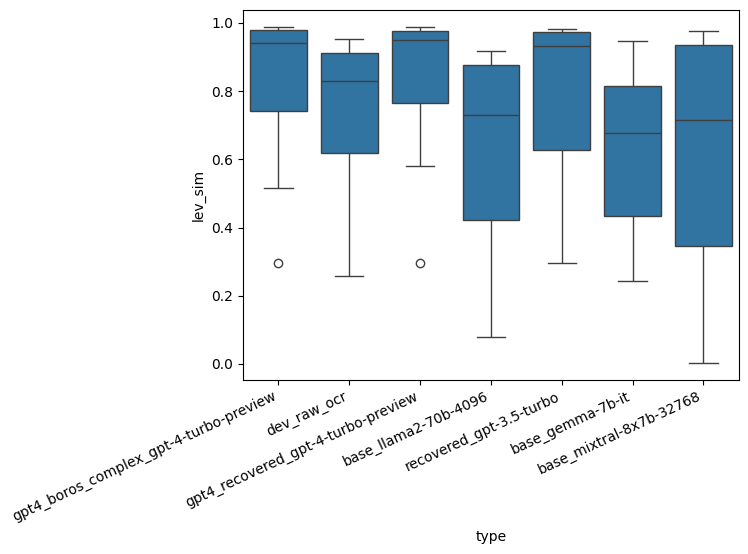

In [29]:
sns.boxplot(data = performance_eval2, x = 'type', y = 'lev_sim')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees

plt.show()

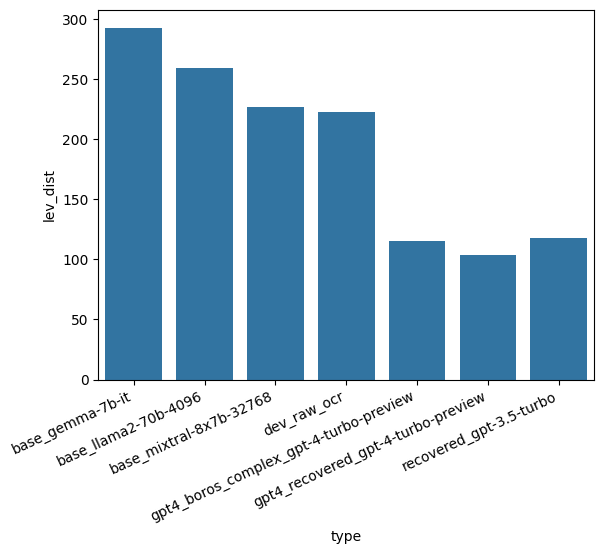

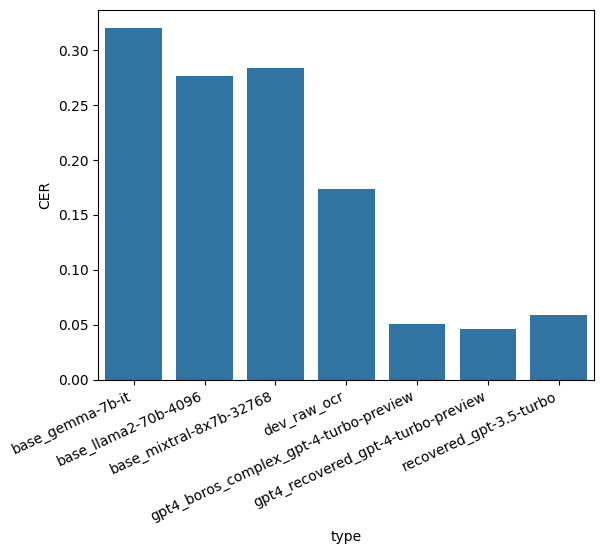

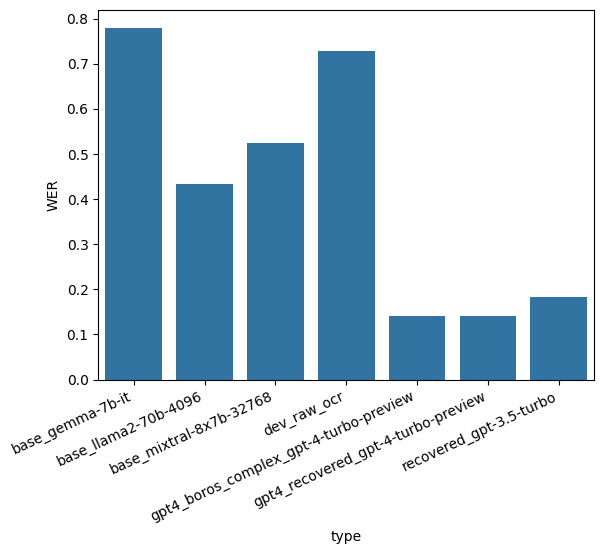

In [30]:
sns.barplot(data = performance_eval2.drop(columns='File Name').groupby('type').median(), x = 'type', y = 'lev_dist')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees

plt.show()

sns.barplot(data = performance_eval2.drop(columns='File Name').groupby('type').median(), x = 'type', y = 'CER')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees

plt.show()


sns.barplot(data = performance_eval2.drop(columns='File Name').groupby('type').median(), x = 'type', y = 'WER')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees

plt.show()

In [29]:
performance_eval.loc[performance_eval['type']=='base2_mixtral-8x7b-32768'].drop(columns = 'type').to_csv('data/mixtral_errors.csv')

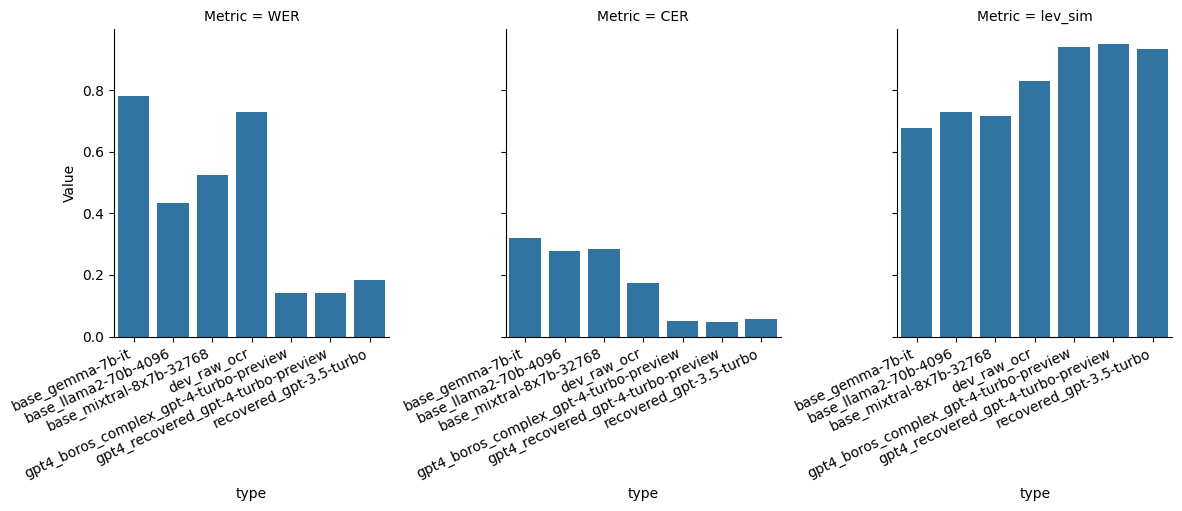

In [31]:
median_df = performance_eval2.drop(columns='File Name').drop(columns = 'lev_dist').groupby('type').median().reset_index()

# Melt the DataFrame to long format
long_df = pd.melt(median_df, id_vars='type', var_name='Metric', value_name='Value')

# Use seaborn's catplot to create a faceted plot
g = sns.catplot(
    data=long_df, 
    x='type', 
    y='Value', 
    col='Metric', 
    kind='bar',
    height=4, 
    aspect=1, # Adjust the aspect ratio and size of each facet
    col_wrap=3, # Number of columns for facets
)

g.set_xticklabels(rotation=25, ha='right') # Rotate x-axis labels

plt.show()

## Classifying genre

In [16]:
#The below did not work well. Hwoever, supplying the list as part of the system message did

system_message = f""" You are an expert in classifying newspaper articles"""
prompt = f"""
                Read following article.
                :::
                {truncated_text}
                :::

                Now without returning anyother text, select from the list below a single entry that most represents the genre of the article you just read
                ::::
                news report
                editorial
                letter
                advert
                review
                poem/song/story
                other
                ::::
                
                """

system_message = """You will be provided with text from a newspaper. Classify the text into a single category

                The categories are
                - news report
                - editorial
                - letter
                - advert
                - review
                - poem/song/story
                - other
                """

#
# This was based on open ai prompt advice, but it doesn't work so well

system_message = """You will be provided with text from a newspaper. Classify the text into a single category

                The categories are
                - news report
                - editorial
                - letter
                - advert
                - review
                - poem/song/story
                - other
                """
prompt = f"""{truncated_text}"""

system_message = f""" You are a machine that classifies newspaper articles. Your response  is limited to a single choice from the following list
    
                    ::::
                    news report
                    editorial
                    letter
                    advert
                    review
                    poem/song/story
                    other
                    ::::
                    For example given the text "Mr Bronson died today, he was a kind man" your answer would be
                    other"""


system_message = """ You are a machine that classifies newspaper articles. Your response  is limited to choices from the following json
                        {0: 'news report',
                        1: 'editorial',
                        2: 'letter',
                        3: 'advert',
                        4: 'review',
                        5: 'poem/song/story',
                        6: 'other'}
                        you will respond using a single digit.

                    For example given the text "Mr Bronson died today, he was a kind man" your answer would be
                    6
                    
                    Alternatively given the text "The prime minster spoke at parliament today" your answer would be
                    0
                    """

In [17]:
"""
                    Read the list of article genres for newspapers
                    ::::
                    ['news report', 'editorial', 'letter', 'advert', 'review', 'poem/song/story', 'other']
                    ::::
                    Now read the article below, surrounded by 3 colons, return a single word from the list of genres that most appropriately match the text
                    :::
                    {truncated_text}
                    :::
                    """

system_message = """I wish to classify an article from a newspaper into 1 of the following classes 
['news report', 'editorial', 'letter', 'advert', 'review', 'poem/song/story', 'other']. 
The article is from {title}, a newspaper printed in England in {date}. Please respond with a single word, that word being the class of the article taken from the list.
"""


In [19]:

rate_limiter = RateLimiter(50000)

list_classes = []
start_time = time.time()  # Capture start time
for i, row in test_data.iterrows():
    
    temp = classify_genre_row(row, rate_limiter, engine="gpt-3.5-turbo-0125")
    list_classes.append(temp)
    
    # Print execution time every 10 iterations
    if (i + 1) % 10 == 0:  
        end_time = time.time()  # Capture end time
        print(f"Iteration {i + 1}: Function execution time: {round((end_time - start_time)/10,1)} seconds per iter")
        start_time = time.time()  # Capture start time

test_data['article_class'] = list_classes


Iteration 10: Function execution time: 0.5 seconds per iter
Iteration 20: Function execution time: 0.5 seconds per iter
Iteration 30: Function execution time: 0.7 seconds per iter
Iteration 40: Function execution time: 0.8 seconds per iter
Iteration 50: Function execution time: 0.6 seconds per iter
Iteration 60: Function execution time: 0.7 seconds per iter
Iteration 70: Function execution time: 0.6 seconds per iter
Iteration 80: Function execution time: 0.7 seconds per iter
Iteration 90: Function execution time: 0.7 seconds per iter
Iteration 100: Function execution time: 0.6 seconds per iter
Iteration 110: Function execution time: 0.6 seconds per iter
Iteration 120: Function execution time: 0.6 seconds per iter
Iteration 130: Function execution time: 0.7 seconds per iter
Iteration 140: Function execution time: 60.8 seconds per iter
Iteration 150: Function execution time: 0.6 seconds per iter
Iteration 160: Function execution time: 0.8 seconds per iter
Iteration 170: Function executio

In [27]:
test_data.groupby('article_class').size()

NameError: name 'test_data' is not defined

In [147]:
test_data

,Unnamed: 0,id,article_type_id,issue_date,publication_id,content_html,total_tokens,symbol_fract,title,gpt4_response,gpt35_response,article_topics,article_class
0,0,796586,1,1870-04-16,19,Chuck : a Comic Tale . In Three Parts . By the...,116,0.155172,Tomahawk,```\nChuck: a Comic Tale. In Three Parts. By t...,**Chuck: a Comic Tale**\n\n*In Three Parts*\n\...,[0],poem/song/story
1,1,794779,1,1870-02-19,19,"Pall ciety Our . Mall But ar , istocr the has ...",374,0.056150,Tomahawk,"Pall Mall Gazette. But aristocracy has, of a s...","**Pall Mall Gazette**\n\nOur society paper, Pa...",[7],editorial
2,2,796786,1,1870-08-27,19,( generall According y at periods to our conte...,223,0.067265,Tomahawk,According to our contemporaries of a fortnight...,According to our contemporaries of a fortnight...,[10],editorial
3,3,799950,1,1867-09-07,19,"Shadowy Praise . —Mr . Tom Taylor , apropos of...",321,0.118380,Tomahawk,"Shadowy Praise.—Mr. Tom Taylor, apropos of his...","# Shadowy Praise\n\nMr. Tom Taylor, apropos of...",[0],editorial
4,4,795213,1,1870-06-18,19,"Su i ^ Untorg OK CHARLES DICKENS , Author and ...",124,0.056452,Tomahawk,"Subject: In Memory of CHARLES DICKENS, Author ...","# Sunforged of CHARLES DICKENS, Author and Phi...","[0, 11]",poem/song/story
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,931191,2,1845-03-08,27,PR . GRANDISON'S NEltVOUS PILLS . nECOMMENDED ...,215,0.125581,Northern Star,```\nDR. GRANDISON'S NERVOUS PILLS\nRECOMMENDE...,**PR. GRANDISON'S NERVOUS PILLS**\n\n**RECOMME...,[6],advert
216,216,853954,2,1851-05-31,27,SKCRET SORfiOW ! CERTAIN HELP ! Immense succes...,292,0.164384,Northern Star,```\nSECRET SORROW! CERTAIN HELP!\nImmense suc...,**SECRET SORROW! CERTAIN HELP!**\n\nImmense su...,[6],advert
217,217,709760,2,1843-08-12,27,"Now on Sale , Price Sixpence , No . III . of a...",137,0.138686,Northern Star,"```\nNow on Sale, Price Sixpence, No. III. of ...",# Now on Sale\n\nPrice Sixpence\n\nNo. III. of...,[3],advert
218,218,822644,2,1842-09-10,27,"TO THE EDITOR 6 F THE NORTHERN STAR . Lees , n...",160,0.118750,Northern Star,"TO THE EDITOR OF THE NORTHERN STAR\n\nLees, ne...",**TO THE EDITOR OF THE NORTHERN STAR** \n*Lee...,"[1, 13]",letter


# Create test set

In [21]:
perform_capoc(train_data, 'silver_labels', system_message_template, engine = 'gpt-4-turbo-preview', data_path='./data',  alt_endpoint = None)

# IPTC topics

There are only 17 main topics and 130 level two topic. broadly level one topics are a detailed enough way to classify the data, although it could be argued that in certain cases a more detailed approach would be valuable. One such case is 'politics' as the 1800's UK experienced a lot of political change, and so perhaps more detail on the nature of the coverage would be valuable. However, for simplicity using top level classification is more sensible as the number of articles reporting on second level topics like "cyber warfare", or 'online and remote learning' are likely to be limited. However, given the hierarchical nature of the NewsCodes, adding detail onto relvant subsets is straight forward and can be performed when appropriate

In [59]:
import json

# Load JSON data from file
with open('./data/IPTC_NewsCodes.json', 'r') as f:
    data = json.load(f)

# Convert nested level 2 dictionary to pandas DataFrame
df = pd.DataFrame(data['conceptSet'])

df = df[['uri', 'qcode', 'prefLabel','definition', 'narrower', 'broader']]
# Now df contains your data as a pandas DataFrame
df['prefLabel'] = df['prefLabel'].apply(lambda x: x['en-GB'])
df['definition'] = df['definition'].apply(lambda x: x['en-GB'])
df['qcode2'] = df['qcode'].str.replace("medtop:", "")

df['list_length'] = df['broader'].apply(lambda x: len(x) if isinstance(x, list) else None) #all are 1 long meaning there is only 2 parent. easy to manage!

df['broader'] = df['broader'].apply(lambda x: os.path.basename(x[0]) if isinstance(x, list) and len(x) > 0 else None)


In [76]:

df.loc[df['broader'].isna()]

,uri,qcode,prefLabel,definition,narrower,broader,qcode2,list_length
0,http://cv.iptc.org/newscodes/mediatopic/01000000,medtop:01000000,"arts, culture, entertainment and media","All forms of arts, entertainment, cultural her...","[medtop:20000002, medtop:20000038, medtop:2000...",None,01000000,NaN
1,http://cv.iptc.org/newscodes/mediatopic/02000000,medtop:02000000,"crime, law and justice",The establishment and/or statement of the rule...,"[medtop:20000082, medtop:20000106, medtop:2000...",None,02000000,NaN
2,http://cv.iptc.org/newscodes/mediatopic/03000000,medtop:03000000,"disaster, accident and emergency incident",Man made or natural event resulting in loss of...,"[medtop:20000139, medtop:20000148, medtop:2000...",None,03000000,NaN
3,http://cv.iptc.org/newscodes/mediatopic/04000000,medtop:04000000,"economy, business and finance","All matters concerning the planning, productio...","[medtop:20000170, medtop:20000209, medtop:2000...",None,04000000,NaN
4,http://cv.iptc.org/newscodes/mediatopic/05000000,medtop:05000000,education,"All aspects of furthering knowledge, formally ...","[medtop:20000398, medtop:20000399, medtop:2000...",None,05000000,NaN
5,http://cv.iptc.org/newscodes/mediatopic/06000000,medtop:06000000,environment,"All aspects of protection, damage, and conditi...","[medtop:20000418, medtop:20000420, medtop:2000...",None,06000000,NaN
6,http://cv.iptc.org/newscodes/mediatopic/07000000,medtop:07000000,health,All aspects of physical and mental well-being,"[medtop:20000446, medtop:20000461, medtop:2000...",None,07000000,NaN
7,http://cv.iptc.org/newscodes/mediatopic/08000000,medtop:08000000,human interest,"Item that discusses individuals, groups, anima...","[medtop:20000497, medtop:20000498, medtop:2000...",None,08000000,NaN
8,http://cv.iptc.org/newscodes/mediatopic/09000000,medtop:09000000,labour,"Social aspects, organisations, rules and condi...","[medtop:20000509, medtop:20000521, medtop:2000...",None,09000000,NaN
9,http://cv.iptc.org/newscodes/mediatopic/10000000,medtop:10000000,lifestyle and leisure,"Activities undertaken for pleasure, relaxation...","[medtop:20000538, medtop:20000565, medtop:2000...",None,10000000,NaN


In [65]:
combined_list = sum(df.loc[df['broader'].isna(), 'narrower'], [])

# Extract unique entries
unique_entries = list(set(combined_list))

print(unique_entries)

['medtop:20000502', 'medtop:20001103', 'medtop:20000446', 'medtop:20000148', 'medtop:20000461', 'medtop:20000412', 'medtop:20000536', 'medtop:20000705', 'medtop:20000483', 'medtop:20000593', 'medtop:20000073', 'medtop:20001301', 'medtop:20001130', 'medtop:20000538', 'medtop:20001126', 'medtop:20000399', 'medtop:20000808', 'medtop:20000385', 'medtop:20000056', 'medtop:20000503', 'medtop:20000802', 'medtop:20000497', 'medtop:20000504', 'medtop:20000170', 'medtop:20000647', 'medtop:20000768', 'medtop:20000480', 'medtop:20000038', 'medtop:20000160', 'medtop:20000741', 'medtop:20000770', 'medtop:20000523', 'medtop:20000756', 'medtop:20000499', 'medtop:20000689', 'medtop:20001373', 'medtop:20000648', 'medtop:20000398', 'medtop:20000509', 'medtop:20000715', 'medtop:20000521', 'medtop:20000139', 'medtop:20001108', 'medtop:20000735', 'medtop:20000430', 'medtop:20001237', 'medtop:20000002', 'medtop:20000799', 'medtop:20000574', 'medtop:20001128', 'medtop:20000788', 'medtop:20001324', 'medtop:200

In [113]:
df2 = df.loc[df['broader'].isna()].copy().reset_index()
dictionary = {}
for index, value in df2['prefLabel'].items():
    dictionary[index] = value



{0: 'arts, culture, entertainment and media',
 1: 'crime, law and justice',
 2: 'disaster, accident and emergency incident',
 3: 'economy, business and finance',
 4: 'education',
 5: 'environment',
 6: 'health',
 7: 'human interest',
 8: 'labour',
 9: 'lifestyle and leisure',
 10: 'politics',
 11: 'religion',
 12: 'science and technology',
 13: 'society',
 14: 'sport',
 15: 'conflict, war and peace',
 16: 'weather'}

In [142]:
rate_limiter = RateLimiter(50000)

list_classes = []
start_time = time.time()  # Capture start time
for i, row in test_data.iterrows():
    
    temp = classify_topics_row(row, rate_limiter, engine="gpt-3.5-turbo-0125")
    list_classes.append(temp)
    
    # Print execution time every 10 iterations
    if (i + 1) % 10 == 0:  
        end_time = time.time()  # Capture end time
        print(f"Iteration {i + 1}: Function execution time: {round((end_time - start_time)/10,1)} seconds per iter")
        print(temp)
        start_time = time.time()  # Capture start time

test_data['article_topics'] = list_classes


Iteration 10: Function execution time: 0.6 seconds per iter
[0]
Iteration 20: Function execution time: 0.6 seconds per iter
[1]
Iteration 30: Function execution time: 0.5 seconds per iter
[9]
Iteration 40: Function execution time: 2.4 seconds per iter
[9]
Iteration 50: Function execution time: 0.6 seconds per iter
[15]
Iteration 60: Function execution time: 0.6 seconds per iter
[11]
Iteration 70: Function execution time: 0.8 seconds per iter
[0]
Iteration 80: Function execution time: 0.7 seconds per iter
[3]
Iteration 90: Function execution time: 0.6 seconds per iter
[11]
Iteration 100: Function execution time: 2.2 seconds per iter
[11]
Iteration 110: Function execution time: 12.5 seconds per iter
[10]
Iteration 120: Function execution time: 0.6 seconds per iter
[4, 9]
Iteration 130: Function execution time: 0.5 seconds per iter
[0]
Iteration 140: Function execution time: 0.6 seconds per iter
[0]
Iteration 150: Function execution time: 0.6 seconds per iter
[0]
Iteration 160: Function e

In [143]:
test_data

,Unnamed: 0,id,article_type_id,issue_date,publication_id,content_html,total_tokens,symbol_fract,title,gpt4_response,gpt35_response,article_topics
0,0,796586,1,1870-04-16,19,Chuck : a Comic Tale . In Three Parts . By the...,116,0.155172,Tomahawk,```\nChuck: a Comic Tale. In Three Parts. By t...,**Chuck: a Comic Tale**\n\n*In Three Parts*\n\...,[0]
1,1,794779,1,1870-02-19,19,"Pall ciety Our . Mall But ar , istocr the has ...",374,0.056150,Tomahawk,"Pall Mall Gazette. But aristocracy has, of a s...","**Pall Mall Gazette**\n\nOur society paper, Pa...",[7]
2,2,796786,1,1870-08-27,19,( generall According y at periods to our conte...,223,0.067265,Tomahawk,According to our contemporaries of a fortnight...,According to our contemporaries of a fortnight...,[10]
3,3,799950,1,1867-09-07,19,"Shadowy Praise . —Mr . Tom Taylor , apropos of...",321,0.118380,Tomahawk,"Shadowy Praise.—Mr. Tom Taylor, apropos of his...","# Shadowy Praise\n\nMr. Tom Taylor, apropos of...",[0]
4,4,795213,1,1870-06-18,19,"Su i ^ Untorg OK CHARLES DICKENS , Author and ...",124,0.056452,Tomahawk,"Subject: In Memory of CHARLES DICKENS, Author ...","# Sunforged of CHARLES DICKENS, Author and Phi...","[0, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,931191,2,1845-03-08,27,PR . GRANDISON'S NEltVOUS PILLS . nECOMMENDED ...,215,0.125581,Northern Star,```\nDR. GRANDISON'S NERVOUS PILLS\nRECOMMENDE...,**PR. GRANDISON'S NERVOUS PILLS**\n\n**RECOMME...,[6]
216,216,853954,2,1851-05-31,27,SKCRET SORfiOW ! CERTAIN HELP ! Immense succes...,292,0.164384,Northern Star,```\nSECRET SORROW! CERTAIN HELP!\nImmense suc...,**SECRET SORROW! CERTAIN HELP!**\n\nImmense su...,[6]
217,217,709760,2,1843-08-12,27,"Now on Sale , Price Sixpence , No . III . of a...",137,0.138686,Northern Star,"```\nNow on Sale, Price Sixpence, No. III. of ...",# Now on Sale\n\nPrice Sixpence\n\nNo. III. of...,[3]
218,218,822644,2,1842-09-10,27,"TO THE EDITOR 6 F THE NORTHERN STAR . Lees , n...",160,0.118750,Northern Star,"TO THE EDITOR OF THE NORTHERN STAR\n\nLees, ne...",**TO THE EDITOR OF THE NORTHERN STAR** \n*Lee...,"[1, 13]"


# 1837 overlap



In [ ]:
df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id',  'continuation_from_id', 
                    'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[(df['issue_date']>=pd.to_datetime('1837-01-01').date()) & 
                (df['issue_date']<=pd.to_datetime('1837-12-31').date()), :]

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


In [ ]:
#This shows the 1837 cannot be used to compare between these two papers

df.groupby('publication_id')['issue_date'].agg(['min', 'max'])



,min,max
publication_id,,
22,1837-01-02,1837-12-01
27,1837-12-02,1837-12-16


In [ ]:
del df

# Consider the overlap between english womans and leader

In [ ]:
df['issue_date'].iat[0]

datetime.date(1864, 8, 1)

In [ ]:
16000*10/677

236.3367799113737

In [ ]:
df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id',  'continuation_from_id', 
                    'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[df['publication_id'].isin([20,24]) & (df['issue_date']>=pd.to_datetime('1858-01-01').date()) & 
                (df['issue_date']<=pd.to_datetime('1860-12-31').date()), :]

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


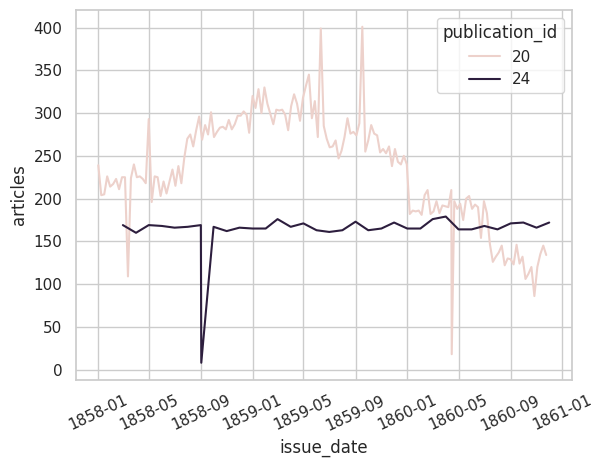

In [ ]:
df2 = df.loc[df['article_type_id']!=2].groupby(['issue_date', 'publication_id']).size().reset_index().rename(columns={0:'articles'})

sns.lineplot(data = df2, x = 'issue_date', y = 'articles', hue ='publication_id')

plt.xticks(rotation=25)  # Rotate x-axis labels to 25 degrees

plt.show()